<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Self_supervised_contrastive_learning_with_SimSiam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128 
EPOCHS = 5
CROP_TO = 32
SEED = 26

PROJECT_DIM = 2048 
LATENT_DIM = 512 
WEIGHT_DECAY = 0.0005 

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170500096/170498071 [==============================] - 2s 0us/step
Total training examples: 50000
Total test examples: 10000


In [ ]:
x_train[0].shape

(32, 32, 3)

In [ ]:
def flip_random_crop(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
  return image 

def color_jitter(x, strength = [0.4, 0.4, 0.4, 0.1]):
  x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
  x = tf.image.random_contrast(x, lower = 1 -0.8 * strength[1], upper = 1 + 0.8 * strength[1])
  x = tf.image.random_saturation(x, lower = 1-0.8 * strength[2], upper=1 +0.8 *strength[2])
  x = tf.image.random_hue(x, max_delta = 0.2 * strength[3])

  x = tf.clip_by_value(x, 0, 255)

  return x 

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image


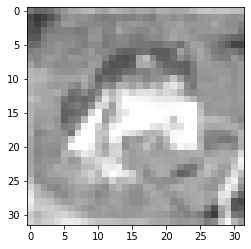

In [ ]:
a = x_train[0]


b = custom_augment(a)

plt.imshow(b)


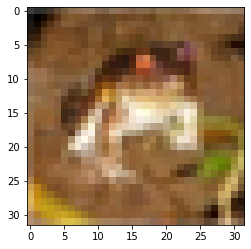

In [ ]:
a = x_train[0]

plt.imshow(a)

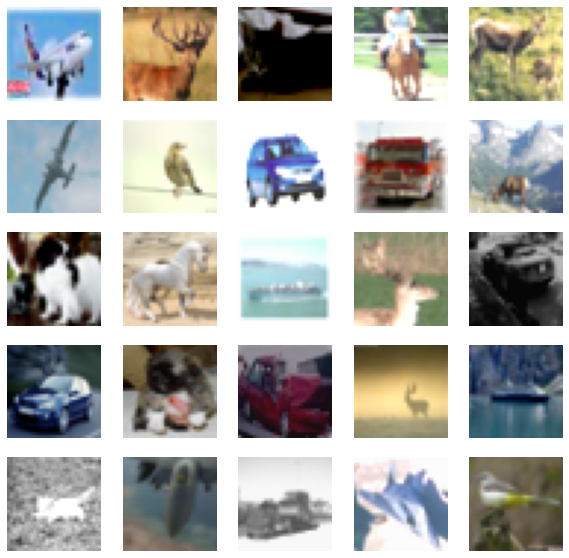

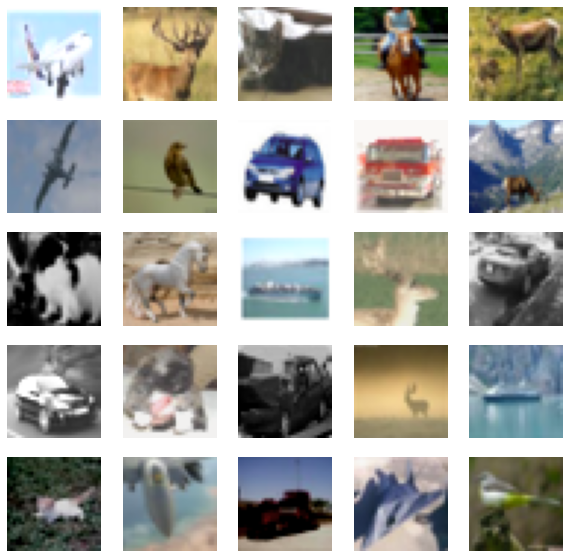

In [ ]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (ssl_ds_one.shuffle(1024, seed= SEED).map(custom_augment, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10,10))
for n in range(25):
  ax = plt.subplot(5,5, n+1)
  plt.imshow(sample_images_one[n].numpy().astype('int'))
  plt.axis('off')
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images



# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [ ]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [ ]:
import resnet_cifar10_v2

N = 2 
DEPTH = N * 9 +2 
NUM_BLOCKS = ((DEPTH - 2)//9) -1 

def get_encoder():
  inputs = layers.Input((CROP_TO, CROP_TO, 3))
  x = layers.experimental.preprocessing.Rescaling(scale= 1.0 / 127.5, offset = -1)(inputs)
  x = resnet_cifar10_v2.stem(x)
  x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
  x = layers.GlobalAveragePooling2D(name = 'backbone_pool')(x)

  # Projection head.
  x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Dense(PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
  outputs = layers.BatchNormalization()(x)
  return tf.keras.Model(inputs, outputs, name = 'encoder')


def get_predictor():
  model = tf.keras.Sequential([
                               layers.Input((PROJECT_DIM,)),
                               layers.Dense(LATENT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
                               layers.ReLU(),
                               layers.BatchNormalization(),
                               layers.Dense(PROJECT_DIM)
  ], name = 'predictor')
  return model 


In [ ]:
def compute_loss(p, z):
  # The authors of SimSiam emphasize the impact of
  # the `stop_gradient` operator in the paper as it
  # has an important role in the overall optimization.

  z = tf.stop_gradient(z)
  p = tf.math.l2_normalize(p, axis= 1)
  z = tf.math.l2_normalize(z, axis =1)
  # Negative cosine similarity (minimizing this is
  # equivalent to maximizing the similarity).
  return -tf.reduce_mean(tf.reduce_sum((p*z), axis =1))

In [ ]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Epoch 1/5
391/391 [==============================] - 78s 114ms/step - loss: -0.8701
Epoch 2/5
391/391 [==============================] - 44s 113ms/step - loss: -0.8929
Epoch 3/5
391/391 [==============================] - 45s 115ms/step - loss: -0.8990
Epoch 4/5
391/391 [==============================] - 45s 116ms/step - loss: -0.9017
Epoch 5/5
391/391 [==============================] - 46s 117ms/step - loss: -0.9028


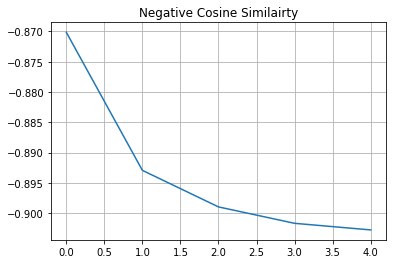

In [ ]:
# Create a cosine decay learning scheduler.
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [ ]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

In [ ]:
# Extract the backbone ResNet20.
backbone = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

In [ ]:
# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(10, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/5
391/391 [==============================] - 10s 20ms/step - loss: 3.7878 - accuracy: 0.1606 - val_loss: 3.7157 - val_accuracy: 0.2031
Epoch 2/5
391/391 [==============================] - 7s 17ms/step - loss: 3.7101 - accuracy: 0.2039 - val_loss: 3.6855 - val_accuracy: 0.2190
Epoch 3/5
391/391 [==============================] - 7s 17ms/step - loss: 3.6857 - accuracy: 0.2178 - val_loss: 3.6721 - val_accuracy: 0.2278
Epoch 4/5
391/391 [==============================] - 7s 18ms/step - loss: 3.6756 - accuracy: 0.2245 - val_loss: 3.6672 - val_accuracy: 0.2290
Epoch 5/5
79/79 [==============================] - 1s 13ms/step - loss: 3.6664 - accuracy: 0.2272
Test accuracy: 22.72%
